# Le transfer learning, ou comment construire une baseline facilement

On a vu plus tôt un modèle avancé en Classification qui a remporté un grand succès lors de concours sur des millions d'images : **VGG-16**

Ces modèles possèdent de nombreuses couches, et donc une importante capacité d'abstraction ; ces couches ont été entrainées pendant des milliers d'epochs, et les pattern appris par ces niveaux d'abstraction peuvent donc être supposés robustes pour l'interprétation de données visuelles.

Et si on pouvait réutiliser ce modèle déjà entraîné pour nos propres problèmes ? On peut imaginer plusieurs manières de le faire :

- récupérer le modèle entrainé, et isoler les classes qui correspondent à ce que l'on cherche (si c'est possible !)
- récupérer le modèle entrainé, et changer le classifier - le bloc qui fait la classification, pour un bloc qui opère la classification pour notre problème

Ces deux méthodes supposent qu'il est possible de récupérer le modèle entrainé... ce qui est le cas ! Il est d'ailleurs récupérable directement dans keras par l'appel suivant :



```
model = keras.applications.VGG16()
```

On peut d'ailleurs lui demander directement de ne pas nous inclure le bloc de classification, pour que l'on puisse ajouter le notre à la suite, avec le paramètre " include_top = False"

Il ne nous reste alors qu'à ajouter notre propre bloc de classifications pour le faire correspondre à notre problématique, et à entrainer le réseau construit de cette manière !

Voyons comment celà se présente dans le code !

Nous commencerons par recharger les données que nous utilisions précédemment dans les notebook cats_and_dogs


--2022-02-17 14:27:39--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 108.177.15.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  99.8MB/s    in 0.7s    

2022-02-17 14:27:40 (99.8 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
100/100 [==============================] - 40s 281ms/step - loss: 0.6274 - acc: 0.6575 - val_loss: 0.5329 - val_acc: 0.7780
Epoch 2/30
100/100 [==============================] - 28s 275ms/step - loss: 0.5490 - acc: 0.7425 - val_loss: 0.4630 - val_acc: 0.7940
Epoch 3/30
100/100 [==============================] - 27s 274ms/step - loss: 0.4980 - acc: 0.7755 - val_loss: 0.4009 - val_acc: 0.8360
Epoch 4/30
100/100 [==============================] - 27s 274ms/step - loss: 0.4589 - acc: 0.8045 - val_loss: 0.3707 - val_acc: 0.8390
Epoch 5/30
100/100 [==============================] - 27s 273ms/step - loss: 0.4471 - acc: 0.8055 - val_loss: 0.3484 - val_acc: 0.8560
Epoch 6/30
100/100 [==============================] - 28s 275ms/step - loss: 0.4243 - acc: 0.8185 - val_loss: 0.3355 - val_acc: 0.8630
Epoch 7/30
100/100 [==============================] - 27s 273ms/step - loss: 0.4064 - acc: 0.8250 - val_loss: 0.3217 - val_acc: 0.8680
Epoch 8/30
100/100 [==============================] - 2

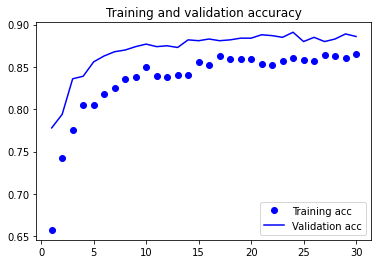

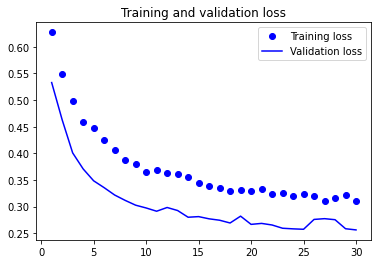

Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


test acc : 0.8859999775886536


In [ ]:

from keras import layers
from keras import models
from tensorflow.keras import optimizers
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.preprocessing import image
import os,shutil
from keras.applications.vgg16 import VGG16
import numpy as np
import keras


### LOADING DATAS

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir=validation_dir
# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150,150),
        batch_size=20,
        class_mode='binary')
validation_generator=test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150,150),
        batch_size=20,
        class_mode='binary')


### LOADING VGG16

conv_base = VGG16(weights='imagenet',
            include_top=False,
            input_shape=(150,150,3))
for layer in conv_base.layers:
    layer.trainable=False
    # if layer.name.split('_')[0]=='block5':
    #   layer.trainable=True

conv_base.summary()

# callbacks_list = [keras.callbacks.EarlyStopping(monitor='acc',patience=3,)
#                 ,keras.callbacks.ModelCheckpoint(filepath='checkpointmodel.h5',monitor='val_loss',save_best_only=True,)]


### ADDING CLASSIFIER
model=models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

### TRAINING AND TESTING
model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=1e-5),
            metrics=['acc'])

history = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=30,
        # callbacks=callbacks_list,
        validation_data=validation_generator,
        validation_steps=50)


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

test_generator=test_datagen.flow_from_directory(
        test_dir,
        target_size=(150,150),
        batch_size=20,
        class_mode='binary')
test_loss,test_acc = model.evaluate_generator(test_generator,steps=50)
print('test acc :', test_acc)


Le transfer learning permet donc d'obtenir très vite des résultats qui peuvent être considérés comme la baseline pour la problématique associée. Pour ce faire, on cherche un modèle performant qui partage avec notre problématique :
- le type de données
- le type de problème (régression, détection, ...)

On télécharge le modèle entrainé en question (ou juste les poids qu'on utilisera pour initialiser le modèle).

Il reste alors à remplacer la partie "résolution du problème" (classification précédemmentà) par un solveur neuf qui répond à notre problématique.

En fait, on peut assimiler dans cette méthode l'utilisation du réseau entrainé comme un extracteur de feature auquel on fait suivre un classificateur, comme dans le workflow classique du machine learning ...

